# Named Entity Recognition

NER is a subtask of information extraction that seeks to extract and classify words into predefined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, etc. NER can be used in natural language processing (NLP) to help answer real-world problems. This can be applied to recognize and parse important information from resumes, search for specific products mentioned in complaints or reviews, look for a company name in a news article, and many other uses. Apart from being used as an information extraction tool, it is also a preprocessing step for many NLP applications like machine translation, question answering, and text summarization.

<div align="center">
  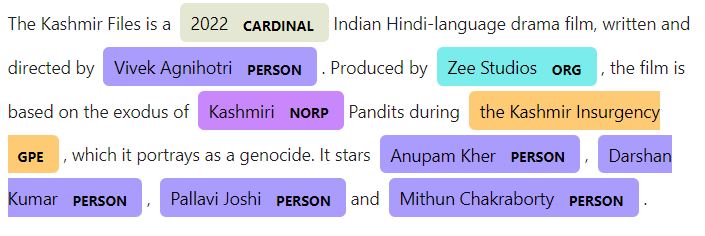
</div>

# Import Libraries

In [34]:
import pandas as pd
import numpy as np
# Importing necessary library for visualization
import plotly.express as px
import tqdm
# Importing the necessary function for sequence padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Importing the necessary function for splitting datasets
from sklearn.model_selection import train_test_split
# Importing necessary modules from Keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras
# 'InputLayer', 'TimeDistributed', and 'SpatialDropout1D' are  types of layers
# 'Bidirectional' is a wrapper that allows a layer (like LSTM) to have bidirectional functionality
# Importing the necessary utility function from Keras
import tensorflow as tf
# Import necessary callbacks from TensorFlow/Keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Import the PlotLossesCallback for live loss plotting
from livelossplot.tf_keras import PlotLossesCallback
# Import the 'joblib' library for reading and writing data to/from files efficiently
import joblib


# Load the dataset

The dataset is from [Kaggle](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus)  , a highly cited dataset used to train NER projects. It is extracted from the Groningen Meaning Bank (GMB), comprises thousands of sentences and words tagged and built specifically to train the classifier to predict named entities. The dataset contains sentences in English and also an annotation for each word.


In [2]:
# Reading the CSV file
data = pd.read_csv('/content/drive/MyDrive/ner_dataset.csv', encoding= 'unicode_escape')

# Filling the missing values in the‘sentence #’ using forward fill method
data = data.fillna(method="ffill")

# Displaying the first 10 rows of the DataFrame
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
# Printing the number of unique words in the 'Word' column of the DataFrame
print("Unique words in corpus:", data['Word'].nunique())

# Printing the number of unique tags in the 'Tag' column of the DataFrame
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [4]:
# Creating a list of unique words in the 'Word' column and adding 'ENDPAD' to the end of the list
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
# Get the last 10 words from the list
words[-10:]

['grassroots',
 'clients',
 'comb',
 'Recently',
 'al-Sadr',
 'Darfur',
 'Iraqi-born',
 'Tashkent',
 'forgive',
 'ENDPAD']

In [5]:
# Creating a list of unique tags in the 'Tag' column
tags = list(set(data["Tag"].values))

# Counting the total number of tags in the list
num_tags = len(tags)
print(num_tags)

17


In [6]:
# Creating a histogram for tags (excluding 'O') using Plotly Express and displaying it
fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()

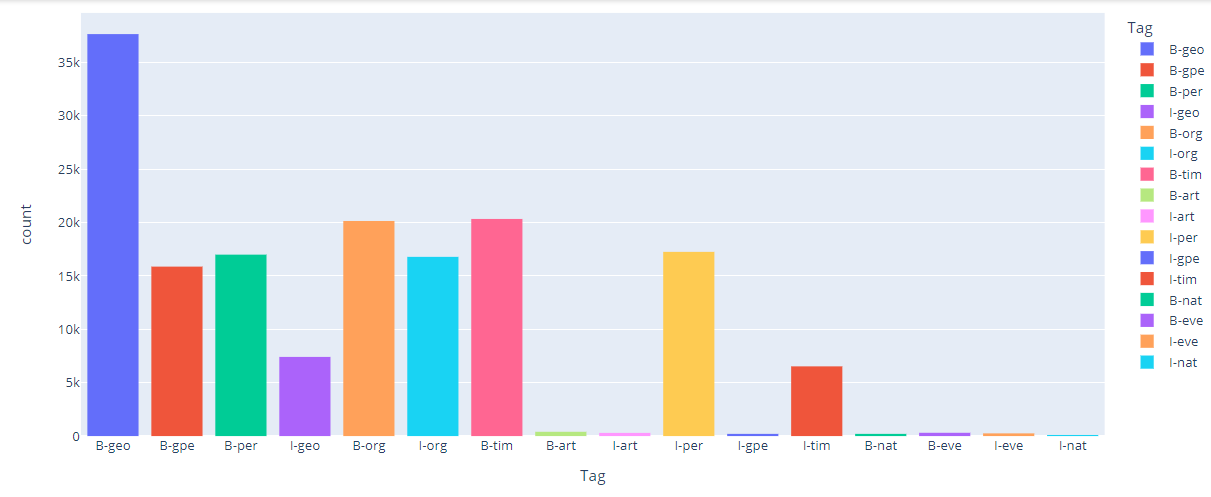

Essential info about tagged entities:

* geo = Geographical Entity

* org = Organization

* per = Person

* gpe = Geopolitical Entity

* tim = Time indicator

* art = Artifact

* eve = Event

* nat = Natural Phenomenon

* The ‘O’ tag represents a word that is not part of an entity.

* The ‘B’ in ‘B-tag’ stands for ‘Beginning’, and it indicates the start of a geographical entity (‘geo’).

* The ‘I’ in ‘I-tag’ stands for ‘Inside’, and it signifies a word inside a geographical entity (‘geo’).


# Data Manipulation (integrate tokens from same sentence)

In [7]:
# Defining a function to integrate sentences in the data
def sentence_integrate(data):
  # This function aggregates the words, POS tags, and entity tags in each sentence
  # It creates a list of tuples, where each tuple contains a word, its POS tag, and its entity tag
  agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                     s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
  # The function is applied to each sentence in the data (grouped by 'Sentence #')
  # The result is a list of lists, where each inner list represents a sentence
  return data.groupby('Sentence #').apply(agg_func).tolist()

This code defines a function sentence_integrate that takes a DataFrame data as input. The DataFrame is assumed to have columns ‘Word’, ‘POS’, and ‘Tag’, and a sentence identifier ‘Sentence #’. The function groups the DataFrame by sentences, and for each sentence, it creates a list of tuples. Each tuple contains a word from the sentence, its part-of-speech (POS) tag, and its entity tag. The function returns a list of these lists.

In [8]:
# Applying the 'sentence_integrate' function to the data
# This will create a list of sentences, where each sentence is a list of tuples
# Each tuple contains a word, its POS tag, and its entity tag
sentences = sentence_integrate(data)

# Displaying the first sentence in the list
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

###Build a vocabulary for words and tags

In [9]:
# Creating a dictionary 'word2idx' where each key is a unique word from the 'words' list
# and the corresponding value is the word's index in the list plus one
word2idx = {w: i + 1 for i, w in enumerate(words)}

# Creating a dictionary 'tag2idx' where each key is a unique tag from the 'tags' list
# and the corresponding value is the tag's index in the list
tag2idx = {t: i for i, t in enumerate(tags)}


In [10]:
# Get a list of the dictionary's items
items = list(word2idx.items())

# Get the first 10 items
first_10_items = items[:10]

# Now 'first_10_items' is a list of tuples, where each tuple is a key-value pair
first_10_items

[('69', 1),
 ('Mojave', 2),
 ('bears', 3),
 ('attracting', 4),
 ('applicants', 5),
 ('Amur', 6),
 ('so-called', 7),
 ('realities', 8),
 ('720', 9),
 ('Chan', 10)]

In [11]:
tag2idx

{'I-org': 0,
 'I-art': 1,
 'I-geo': 2,
 'B-gpe': 3,
 'I-eve': 4,
 'B-nat': 5,
 'B-eve': 6,
 'B-geo': 7,
 'O': 8,
 'I-per': 9,
 'B-org': 10,
 'I-nat': 11,
 'B-tim': 12,
 'I-gpe': 13,
 'I-tim': 14,
 'B-art': 15,
 'B-per': 16}

### Padding Input Sentences &  splitting dataset


The below  code creates a histogram that shows the distribution of sentence lengths in your data. The lengths of the sentences are calculated, and a DataFrame is created from these lengths. A box plot is also displayed along with the histogram to provide additional statistical information about the distribution.



In [12]:
# Creating a DataFrame from the lengths of the sentences
lengths_df = pd.DataFrame([len(s) for s in sentences], columns=['length'])

# Creating a histogram of sentence lengths using Plotly Express
# The 'marginal' parameter is set to 'box' to display a box plot along with the histogram
fig = px.histogram(lengths_df, x="length", marginal='box')

# Displaying the histogram
fig.show()

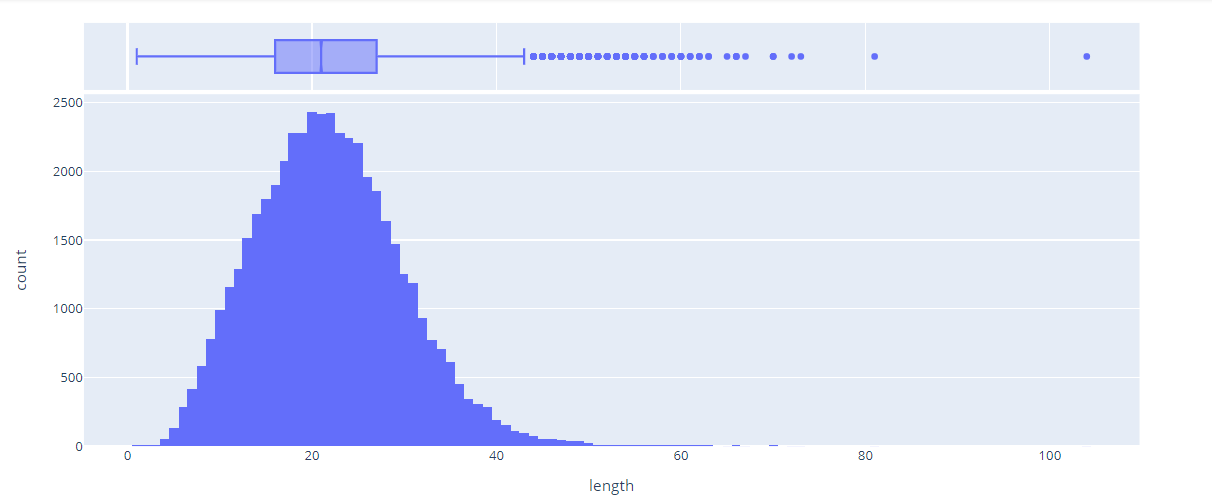

The lengths of the sentences in our dataset range from 0 to 60. However, to maintain a consistent input size for our model, we’ll set a maximum length of 50. This means that all sentences will be padded or truncated to be exactly 50 words long. This process is known as padding. It’s a common technique used in natural language processing to ensure that all sequences in a batch are the same length.

In [13]:
# Setting the maximum length for sequences
max_len = 50

# Converting each sentence into a sequence of word indices
# 'word2idx' is used to map each word to its corresponding index
# Each sentence becomes a list of word indices
X = [[word2idx[w[0]] for w in s] for s in sentences]
X[0]

[31338,
 15755,
 31923,
 17353,
 18523,
 4008,
 180,
 14583,
 11533,
 16810,
 32890,
 33979,
 5274,
 2027,
 32984,
 16810,
 11345,
 15755,
 10041,
 34416,
 29050,
 30029,
 6141,
 13780]

In [14]:
# Padding the sequences to ensure they all have the same length
# Sequences that are shorter than 'max_len' are padded with 'num_words-1' at the end
# Sequences that are longer than 'max_len' are truncated at the end
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
X.shape

(47959, 50)

In [15]:
# Converting each sentence into a sequence of tag indices
# 'tag2idx' is used to map each tag to its corresponding index
# Each sentence becomes a list of tag indices
y = [[tag2idx[w[2]] for w in s] for s in sentences]

# Padding the sequences of tag indices in the same way as the sequences of word indices
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y.shape

(47959, 50)

In [16]:
# Splitting the data into training and testing sets
# 'X' is the list of padded sequences of word indices
# 'y' is the list of padded sequences of tag indices
# 'test_size=0.2' means that 20% of the data will be used for the test set
# 'random_state=1' is used for reproducibility of the results
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


## Build and Compile The Model

I will use  a Bidirectional LSTM Model because  it can capture information from both past (left context) and future (right context) to a specific point in the sequence.

In other words, for each word in a sentence, a BiLSTM not only considers the words that came before it but also the words that come after it. This is particularly useful in NER tasks because the context in which a word appears (the words before and after it) can provide valuable clues about whether it’s an entity and what type of entity it is.

For example, consider the sentence “John lives in New York”. If we’re trying to determine whether “New York” is an entity, knowing that “in” comes before it and that it’s the end of the sentence can help us conclude that “New York” is indeed an entity (a location in this case).

So, by using a BiLSTM, we’re able to make our model more aware of the full context of each word, which can lead to better performance in NER tasks.

In [18]:
# Creating a Sequential model using Keras
model = keras.Sequential()

# Adding an Input Layer with the shape equal to 'max_len'
model.add(InputLayer((max_len)))

# Adding an Embedding layer
# 'input_dim' is the size of the vocabulary (i.e., number of unique words)
# 'output_dim' is the size of the dense vector to represent each word (set to 'max_len' here)
# 'input_length' is the length of input sequences
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))

# Adding a SpatialDropout1D layer, which helps prevent overfitting
# The rate for dropout is set to 0.1
model.add(SpatialDropout1D(0.1))

# Adding a Bidirectional LSTM layer
# 'units' specifies the dimensionality of the output space
# 'return_sequences' is set to True because we're dealing with a sequence prediction problem
# 'recurrent_dropout' is the dropout rate for the recurrent units
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(num_tags, activation="softmax")))
# Printing a summary of the model
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 50, 50)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 200)           120800    
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 50, 17)            3417      
 stributed)                                                      
                                                                 
Total params: 1883167 (7.18 MB)
Trainable params: 1883167 (7.18 MB)
Non-trainable params: 0 (0.00 Byte)
________________

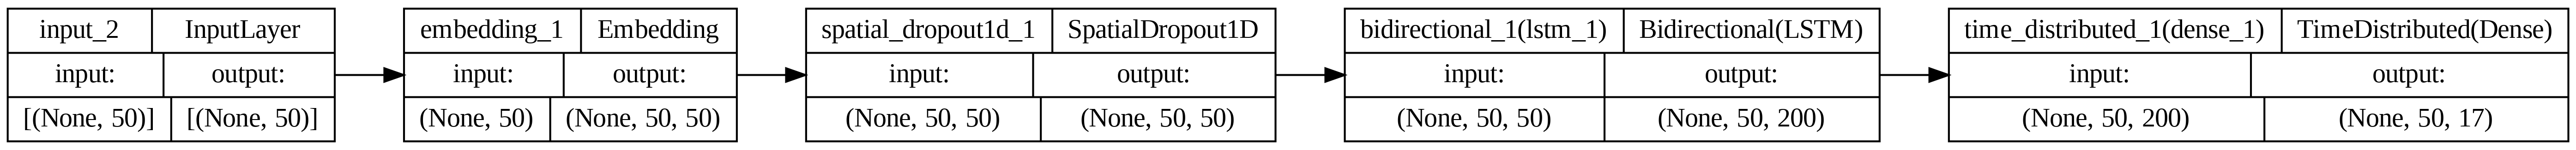

In [19]:
# Using the 'plot_model' utility function to create a plot of the model
# 'model' is the model to be plotted
# 'to_file' is the name of the file to which to save the plot
# 'show_shapes' is set to True to output shapes of layers
# 'show_dtype' is set to False to not output layer dtypes
# 'show_layer_names' is set to True to display layer names
# 'rankdir' is set to 'LR' for left-to-right graph orientation
# 'expand_nested' is set to True to expand nested models into clusters
# 'dpi' controls image quality (dots per inch)
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)


In [20]:
# Compiling the model with specified settings
# 'optimizer="adam"': Using the Adam optimizer for gradient descent
# 'loss="sparse_categorical_crossentropy"': Using sparse categorical cross-entropy loss
# 'metrics=["accuracy"]': Tracking accuracy as an evaluation metric during training
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


 ### Train the Model

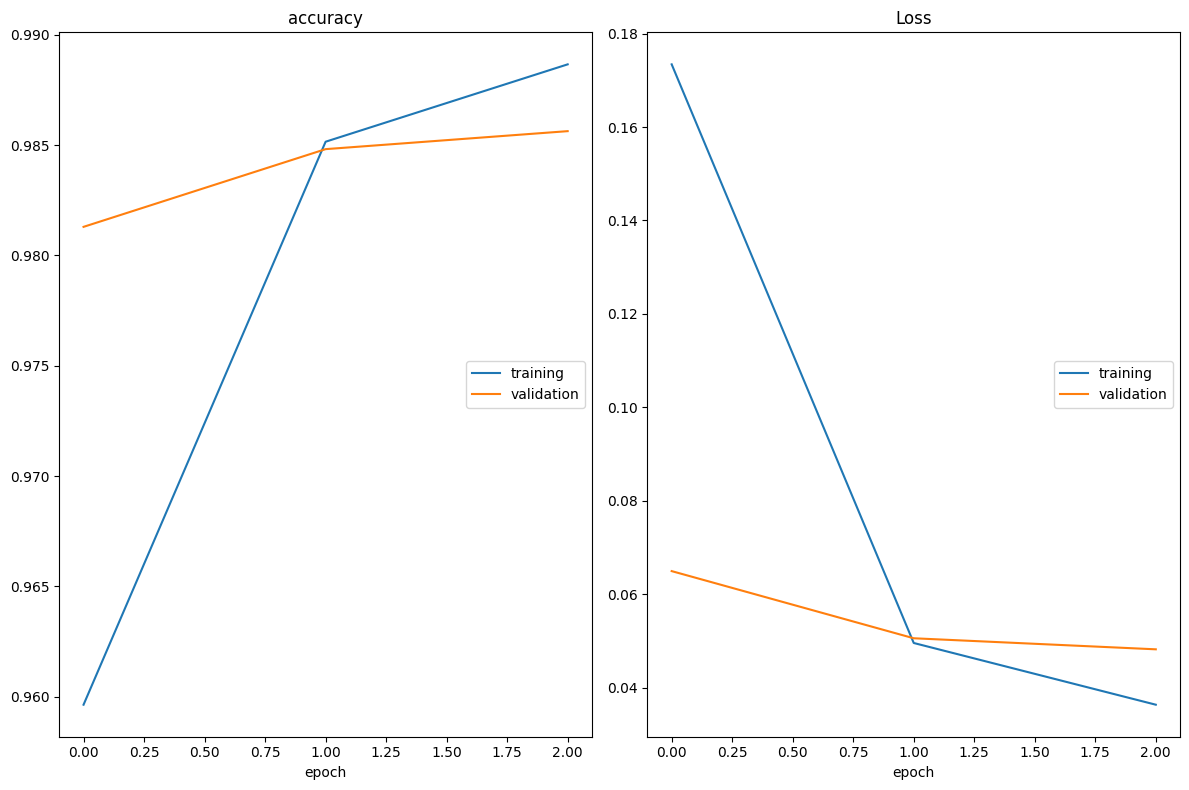

accuracy
	training         	 (min:    0.960, max:    0.989, cur:    0.989)
	validation       	 (min:    0.981, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.036, max:    0.173, cur:    0.036)
	validation       	 (min:    0.048, max:    0.065, cur:    0.048)

Epoch 3: val_loss improved from 0.05055 to 0.04819, saving model to model_weights.h5
1199/1199 [==============================] - 439s 366ms/step - loss: 0.0363 - accuracy: 0.9887 - val_loss: 0.0482 - val_accuracy: 0.9856
CPU times: user 30min 56s, sys: 2min 52s, total: 33min 48s
Wall time: 23min 27s


In [23]:
# Start measuring time
%%time

# Define a ModelCheckpoint callback to save the best model weights during training
chkpt = ModelCheckpoint(
    "model_weights.h5",  # File to save the best model weights
    monitor='val_loss',  # Monitor validation loss
    verbose=1,            # Print progress information
    save_best_only=True,  # Save only the best model weights
    save_weights_only=True,  # Save only the weights (not the entire model)
    mode='min'            # The 'val_loss' should be minimized
)

# Define an EarlyStopping callback to stop training early if validation accuracy stops improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    min_delta=0,             # Minimum change in accuracy to be considered an improvement
    patience=1,              # Number of epochs with no improvement to wait before stopping
    verbose=0,               # Don't print early stopping messages
    mode='max',              # The 'val_accuracy' should be maximized
    baseline=None,           # No baseline accuracy defined
    restore_best_weights=False  # Don't restore the best weights at the end
)

# Combine the callbacks into a list
callbacks = [PlotLossesCallback(), chkpt, early_stopping]

# Train the model using the specified callbacks
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=32,  # Batch size for training
    epochs=3,        # Number of training epochs
    callbacks=callbacks,  # List of callbacks to be used during training
    verbose=1  # Print training progress information
)

#### Export word2idx and tag2index

In [27]:
# Using the joblib library to save the 'word2idx' dictionary to a file
# This dictionary is used for mapping words to their corresponding indices
# 'compress=9' specifies the highest compression level for the saved file
joblib.dump(word2idx, 'word2idx.joblib', compress=9)

# Using the joblib library to save the 'tag2idx' dictionary to a file
# This dictionary is used for mapping tags to their corresponding indices
# 'compress=9' specifies the highest compression level for the saved file
joblib.dump(tag2idx, 'tag2idx.joblib', compress=9)


['tag2idx.joblib']

In [29]:
#Save the model
model.save("ner-model")

####Evaluate Named Entity Recognition Model

In [30]:
# Printing a message to indicate that evaluation on test data is starting
print("Evaluate on test data")

# Using the model to evaluate its performance on the test data
# 'model.evaluate' returns a list of evaluation results, including loss and accuracy
results = model.evaluate(x_test, y_test, batch_size=128)

# Printing the test loss from the evaluation results
print("test loss: {} ".format(results[0]))

# Printing the test accuracy from the evaluation results
print("test accuracy: {} ".format(results[1]))


Evaluate on test data
75/75 [==============================] - 4s 56ms/step - loss: 0.0482 - accuracy: 0.9856
test loss: 0.048188216984272 
test accuracy: 0.9856338500976562 


#### Load trained model

In [31]:
# Loading a pre-trained model from the specified file path
model = tf.keras.models.load_model("ner-model/")

# Loading the 'word2idx' dictionary from a saved file
word2idx = joblib.load("word2idx.joblib")

# Loading the 'tag2idx' dictionary from a saved file
tag2idx = joblib.load("tag2idx.joblib")


In [32]:
# Define a function for making predictions on input text
def predict(text):
    # Define the maximum sequence length for padding
    max_len = 50

    # Calculate the number of words in the input text
    str_len = len(text.split())

    # Convert the input text to a numerical representation using 'word2idx' dictionary
    text = [[word2idx.get(w, 0) for w in text.split()]]

    # Pad the input sequence to the maximum length
    text = pad_sequences(maxlen=max_len, sequences=text, padding="post", value=num_words-1)

    # Make predictions using the loaded model
    p = model.predict(np.array([text[0]]))

    # Find the index of the maximum probability for each word
    p = np.argmax(p, axis=-1)

    # Print header for the prediction results
    print("{:15}\t {}\n".format("Word", "Pred"))
    print("-" * 30)

    # Iterate through the words in the input text and print the corresponding predictions
    for i in range(str_len):
        # Print the word and its predicted tag
        print("{:15}\t{}".format(words[text[0][i]-1], tags[p[0][i]]))


In [35]:
# Calling the predict function with an example input text
predict("this is Cairo from Egypt")


1/1 [==============================] - 1s 675ms/step
Word           	 Pred

------------------------------
this           	O
is             	O
Cairo          	B-geo
from           	O
Egypt          	B-geo


In [45]:
# Calling the predict function with an example input text
predict("John and Mary in Cairo .")


1/1 [==============================] - 0s 73ms/step
Word           	 Pred

------------------------------
John           	B-per
and            	O
Mary           	B-per
in             	O
Cairo          	B-geo
.              	O


There is another good model called :

 CRF stands for Conditional Random Field:

 It is a statistical modeling approach commonly used for sequence labeling tasks like NER. CRF is used to model the conditional probability of assigning labels (in this case, named entity tags) to each element in a sequence (in this case, words in a sentence) based on the context and dependencies between neighboring elements.

 Differance between CRF and LSTM:

* CRF: CRFs are primarily used for sequence labeling tasks, such as Named Entity Recognition (NER) and Part-of-Speech (POS) tagging. CRFs model the dependencies between labels in a sequence and are particularly good at capturing the contextual relationships between adjacent labels.

* LSTM: LSTMs, on the other hand, are used for a wide range of sequence modeling tasks, including sequence classification, language modeling, and machine translation. LSTMs are designed to model sequential dependencies and are often used for tasks that require understanding and generating sequences of varying lengths.